<a href="https://colab.research.google.com/github/componavt/sns4human/blob/main/src/vk/nlp/scikit_learn_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import requests
filename = 'state_tokens.csv'
response = requests.get(f'https://raw.githubusercontent.com/componavt/sns4human/refs/heads/main/data/vk/posts/topics/{filename}')
with gzip.GzipFile(fileobj=BytesIO(response.content), mode='rb') as f:
    tokens = pd.read_csv(f, delimiter=',', encoding='utf-8')['tokens']

In [ ]:
import nltk
import requests
from nltk.tokenize import word_tokenize
!pip install -U pymorphy3
import pymorphy3
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
from nltk.corpus import stopwords
stop_words = stopwords.words("russian")
stop_words += requests.get('https://raw.githubusercontent.com/componavt/sns4human/refs/heads/main/src/vk/nlp/RussianStopWords.txt').text.split('\n')
stop_words += requests.get('https://raw.githubusercontent.com/componavt/sns4human/refs/heads/main/src/vk/nlp/stopwords-ru.txt').text.split()
alphabet = set('–∞–±–≤–≥–¥–µ—ë–∂–∑–∏–π–∫–ª–º–Ω–æ–ø—Ä—Å—Ç—É—Ñ—Ö—Ü—á—à—â—ä—ã—å—ç—é—è-')
morph = pymorphy3.MorphAnalyzer(lang='ru')

In [ ]:
!pip install pymorphy3
import pymorphy3
morph = pymorphy3.MorphAnalyzer(lang='ru')

def process_text(text):
    check_hash = False
    processed_parts = []
    for w in nltk.word_tokenize(text):
      if len(w) == 1:
        continue
      w_tag = morph.parse(w.strip())[0].tag
      if set(w.lower()).issubset(alphabet):
        if w.isalpha() and w.lower():
          if w.isupper() and len(w) <= 3:
              processed_parts.append(w)
          else:
              res = morph.parse(w.lower())[0].normal_form
              if res not in stop_words:
                  processed_parts.append(res)
    result = ' '.join(processed_parts)
    return str(result)

for index, row in df.iterrows():
    text = row['text'].lower()
    df.loc[index, 'normalized'] = process_text(row['text'].lower())


In [ ]:
from sklearn.model_selection import train_test_split
train_docs, test_docs = train_test_split(df, test_size=0.2, random_state=42, shuffle=True) # –ø–æ—Å—á–∏—Ç–∞—Ç—å —Ç–æ—á–Ω–æ—Å—Ç—å –Ω–∞ —Ç–µ—Å—Ç–æ–≤–æ–π —Å–æ—Ç–Ω–µ

In [ ]:
unique_topics = train_docs['topic'].unique()
len(unique_topics)

27

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import joblib
# –°–æ–∑–¥–∞–µ–º –≤–µ–∫—Ç–æ—Äizer
vectorizer = TfidfVectorizer(max_df=.2, min_df=3, max_features=2000)

# –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º —Ç–µ–∫—Å—Ç –≤ –º–∞—Ç—Ä–∏—Ü—É
doc_train_matrix = vectorizer.fit_transform(train_docs['normalized'])

# –ü–æ–ª—É—á–∞–µ–º –Ω–∞–∑–≤–∞–Ω–∏—è –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ (—Å–ª–æ–≤)
words = vectorizer.get_feature_names_out()  # –ò—Å–ø–æ–ª—å–∑—É–µ–º get_feature_names_out()

doc_test_matrix = vectorizer.transform(test_docs['normalized'])
topic_labels = ['–¢–µ–º–∞ {}'.format(i) for i in range(1, 28)]

lda = LatentDirichletAllocation(n_components=27, n_jobs=-1, max_iter=500,
                                learning_method='batch', evaluate_every=5,
                                verbose=1, random_state=42)
lda.fit(doc_train_matrix)



joblib.dump(lda, 'model.pkl')  # –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏
lda = joblib.load('model.pkl')  # –ó–∞–≥—Ä—É–∑–∫–∞ –º–æ–¥–µ–ª–∏

topics_count = lda.components_
topics_prob = topics_count / topics_count.sum(axis=1).reshape(-1, 1)
topics = pd.DataFrame(topics_prob.T,
                      index=words,
                      columns=topic_labels)
topics.head()

In [ ]:
n_words = 12
top_words = {}
for topic, words_ in topics.items():
    top_words[topic] = words_.nlargest(n_words).index.tolist()
pd.DataFrame(top_words)

–¢–µ–º–∞ 1         –¢–µ–º–∞ 2        –¢–µ–º–∞ 3        –¢–µ–º–∞ 4     –¢–µ–º–∞ 5  \
0             –æ–ª–æ–Ω–µ—Ü           —Ç–µ—Å—Ç     —Ñ–µ—Å—Ç–∏–≤–∞–ª—å       –∫–æ–Ω–∫—É—Ä—Å     –ø–∞–º—è—Ç—å   
1              –æ–∑–µ—Ä–æ          –∫–æ–Ω–∫–∫     –∫–æ–ª–ª–µ–∫—Ç–∏–≤   –æ—Ä–≥–∞–Ω–∏–∑–∞—Ü–∏—è     —Å–∫–∞–∑–∫–∞   
2          –≤—Å–ø–æ–º–Ω–∏—Ç—å          –∞–∫—Ü–∏—è     –∏—Å–∫—É—Å—Å—Ç–≤–æ  –æ–±—â–µ—Å—Ç–≤–µ–Ω–Ω—ã–π    –∑–∞–≥–∞–¥–∫–∞   
3      –∞–¥–º–∏–Ω–∏—Å—Ç—Ä–∞—Ü–∏—è  –∑–∞–º–µ—á–∞—Ç–µ–ª—å–Ω—ã–π       –¥–µ—Ç—Å–∫–∏–π  —Ä–µ–≥–∏–æ–Ω–∞–ª—å–Ω—ã–π  –ø–æ—Å–ª–æ–≤–∏—Ü–∞   
4           –æ–Ω–µ–∂—Å–∫–∏–π         –∑–∞–≤—Ç—Ä–∞           —Ö–æ—Ä        –∑–∞—è–≤–∫–∞     –≥–æ—Ä–µ—Ç—å   
5            –ø–æ—Å—ë–ª–æ–∫        —É—Ö–æ–¥–∏—Ç—å   –º–µ—Ä–æ–ø—Ä–∏—è—Ç–∏–µ      —Ç—Ä–∞–¥–∏—Ü–∏—è  –ø–æ–≥–æ–≤–æ—Ä–∫–∞   
6              –ª–∏–Ω–∏—è    –≤–æ–∑–º–æ–∂–Ω–æ—Å—Ç—å      —Å–æ—Å–Ω–æ–≤—ã–π          —Å–∞–π—Ç      —Ç–µ–ø–ª–æ   
7              –æ–∫—Ä—É–≥        –ø—Ä–∏–Ω—è—Ç—å        –ø—Ä–æ–π—Ç–∏       –æ–∫—Ç—è–±—Ä—å      –ø—É—Å—Ç—å   
8   –∑–∞—Ä–µ–≥–∏—Å—Ç—Ä–∏—Ä–æ–≤–∞—Ç—å     —Ñ–æ—Ç–æ–≥—Ä–∞—Ñ–∏—è  –ø–µ—Ç—Ä–æ–∑–∞–≤–æ–¥—Å–∫     —Ñ–µ—Å—Ç–∏–≤–∞–ª—å     —Å–∏–±–∏—Ä—å   
9            –ø—Ä–∏–Ω—è—Ç—å        –ø–ª–æ—Ç–Ω–∏–∫      –Ω–∞—Ä–æ–¥–Ω—ã–π    —Å–æ—Ü–∏–∞–ª—å–Ω—ã–π   –¥–æ–∫—É–º–µ–Ω—Ç   
10       –±–µ–ª–æ–º–æ—Ä—Å–∫–∏–π    –≤–æ–∑—Ä–æ–∂–¥–µ–Ω–∏–µ     –ø—Ä–æ–≤–æ–¥–∏—Ç—å     –ø–æ–¥—Ä–æ–±–Ω—ã–π   –ø–ª–æ—â–∞–¥–∫–∞   
11          —Å—Ç—Ä–∞–Ω–∏—Ü–∞           —é–Ω—ã–π       –ø—Ä–æ—Å—Ç–æ–π        –∫–æ—Å—Ç—é–º    –ø–µ—Ä–µ–≤–æ–¥   

           –¢–µ–º–∞ 6          –¢–µ–º–∞ 7        –¢–µ–º–∞ 8         –¢–µ–º–∞ 9      –¢–µ–º–∞ 10  \
0        –∫–∞–ª–µ–≤–∞–ª–∞      —Ç–≤–æ—Ä—á–µ—Å—Ç–≤–æ        –ø—Ä–∏–º–µ—Ä        —Å–ª–∞–¥–∫–∏–π         –ø–µ—á—å   
1      —Ñ–æ—Ç–æ–≥—Ä–∞—Ñ–∏—è        –Ω–∞—Ä–æ–¥–Ω—ã–π          —è–∑—ã–∫       –Ω–∞—á–∞—Ç—å—Å—è   –ø—Ä—è–∂–∏–Ω—Å–∫–∏–π   
2        —Ö—É–¥–æ–∂–Ω–∏–∫        –∫—É–ª—å—Ç—É—Ä–∞  –æ–ø—É–±–ª–∏–∫–æ–≤–∞—Ç—å         –∑–Ω–∞—Ç–æ–∫          –º–∞–π   
3         –±–ª–∏–∑–∫–∏–π  –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏–æ–Ω–Ω—ã–π         —Å—Ç–µ–Ω–∞     –ø–æ—Å—Ç–∞–Ω–æ–≤–∫–∞      —ç—Å—Å–æ–π–ª–æ   
4            –∫–∏–∂–∏      –∫—É–ª—å—Ç—É—Ä–Ω—ã–π        –Ω–µ–¥–µ–ª—è          –º—É–∑–µ–π   —ç–∫—Å–ø–æ–∑–∏—Ü–∏—è   
5             –º–ª–Ω          –≤—ã–ø—É—Å–∫         –º–µ—Å—è—Ü       –º—É–∑—ã–∫–∞–Ω—Ç        —Å—ä–µ–∑–¥   
6          –±—é–¥–∂–µ—Ç            —Å–æ—é–∑       –ø–æ–¥–∞—Ä–æ–∫       –∂–µ–ª–µ–∑–Ω—ã–π        –±—Ä–∞—Ç—å   
7        —Å—Ä–µ–¥—Å—Ç–≤–æ           —Ü–µ–Ω—Ç—Ä      –Ω–∞–ø–∏—Å–∞—Ç—å        –∫–∞–ª–∏—Ç–∫–∞      —Å—É–æ—è—Ä–≤–∏   
8              —Ä—Ñ        –º–æ–ª–æ–¥—ë–∂—å       —Ñ–∏–Ω—Å–∫–∏–π       –≤—ã—Ö–æ–¥–Ω–æ–π      —Å—É–±–±–æ—Ç–∞   
9      –æ–±—ä–µ–¥–∏–Ω—è—Ç—å     –æ–±—ä–µ–¥–∏–Ω–µ–Ω–∏–µ        –≥—Ä—É–ø–ø–∞          –º–∏–ª—ã–π       –Ω–µ–¥–µ–ª—è   
10          —Å–µ–º—å—è      —Å–æ–≤–º–µ—Å—Ç–Ω—ã–π       –ø–µ—Ä–µ–≤–æ–¥        –≤–æ–µ–Ω–Ω—ã–π  –ø—Ä–∏–æ–Ω–µ–∂—Å–∫–∏–π   
11  –æ—Ç–µ—á–µ—Å—Ç–≤–µ–Ω–Ω—ã–π         –æ–∫—Ç—è–±—Ä—å        —Ö–µ—à—Ç–µ–≥  –ø—Ä–∏–≥–æ—Ç–æ–≤–ª–µ–Ω–∏–µ        —á–∞–ª–Ω–∞   

    ...       –¢–µ–º–∞ 18         –¢–µ–º–∞ 19         –¢–µ–º–∞ 20       –¢–µ–º–∞ 21  \
0   ...         –º—É–∑–µ–π        –ø–∞–º—è—Ç–Ω–∏–∫         –∏–≥—Ä—É—à–∫–∞        –∏–∑–¥–∞—Ç—å   
1   ...      –≤—ã—Å—Ç–∞–≤–∫–∞         –∫–∞–ª–∏—Ç–∫–∞             –∑–∞–ª        –ø–æ–±–µ–¥–∞   
2   ...  –Ω–∞—Ü–∏–æ–Ω–∞–ª—å–Ω—ã–π           —Ç–µ–∞—Ç—Ä       –ø—Ä–æ–≥—Ä–∞–º–º–∞     —Ä—É–Ω–æ–ø–µ–≤–µ—Ü   
3   ...      –∫—É–ª—å—Ç—É—Ä–∞       —Å–ø–µ–∫—Ç–∞–∫–ª—å           –ø–∏—Ä–æ–≥         –æ–±—Ä–∞–∑   
4   ...       –∏—Å—Ç–æ—Ä–∏—è       –∏–Ω—Ç–µ—Ä–µ—Å–Ω–æ            –∫–ª—É–±          –∏–∑–±–∞   
5   ...       —É—á–∞—Å—Ç–∏–µ        –≥–æ—Ä–¥–æ—Å—Ç—å  –ø–µ—Ç—Ä–æ–∑–∞–≤–æ–¥—Å–∫–∏–π     –ø–æ–≥—Ä—É–∂–∞—Ç—å   
6   ...      –ø—Ä–∞–∑–¥–Ω–∏–∫           –≤–Ω–æ–≤—å      –ø–æ—Å—Ç–∞–Ω–æ–≤–∫–∞        –±–æ–ª–æ—Ç–æ   
7   ...         —Ä–∞–π–æ–Ω   –ø—Ä–∏–≥–æ—Ç–æ–≤–ª–µ–Ω–∏–µ            –≤—Ä–∞—á        –º—É–∑—ã–∫–∞   
8   ...         –≥–æ—Å—Ç—å       –∑–∞—Å–µ–¥–∞–Ω–∏–µ         –ø–æ–µ–∑–¥–∫–∞          —è–∑—ã–∫   
9   ...      –æ—Ç–∫—Ä—ã—Ç–∏–µ           —Å

In [ ]:
train_preds = lda.transform(doc_train_matrix)
train_eval = pd.DataFrame(train_preds, columns=topic_labels, index=train_docs.topic)

<ipython-input-27-e2e8dccc8187>:3: FutureWarning: DataFrameGroupBy.idxmax with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  df = train_eval.groupby(level='topic').idxmax(


Text(0.5, 1.0, '–û–±—É—á–µ–Ω–∏–µ: –¢–µ–º–∞—Ç–∏–∫–∏')

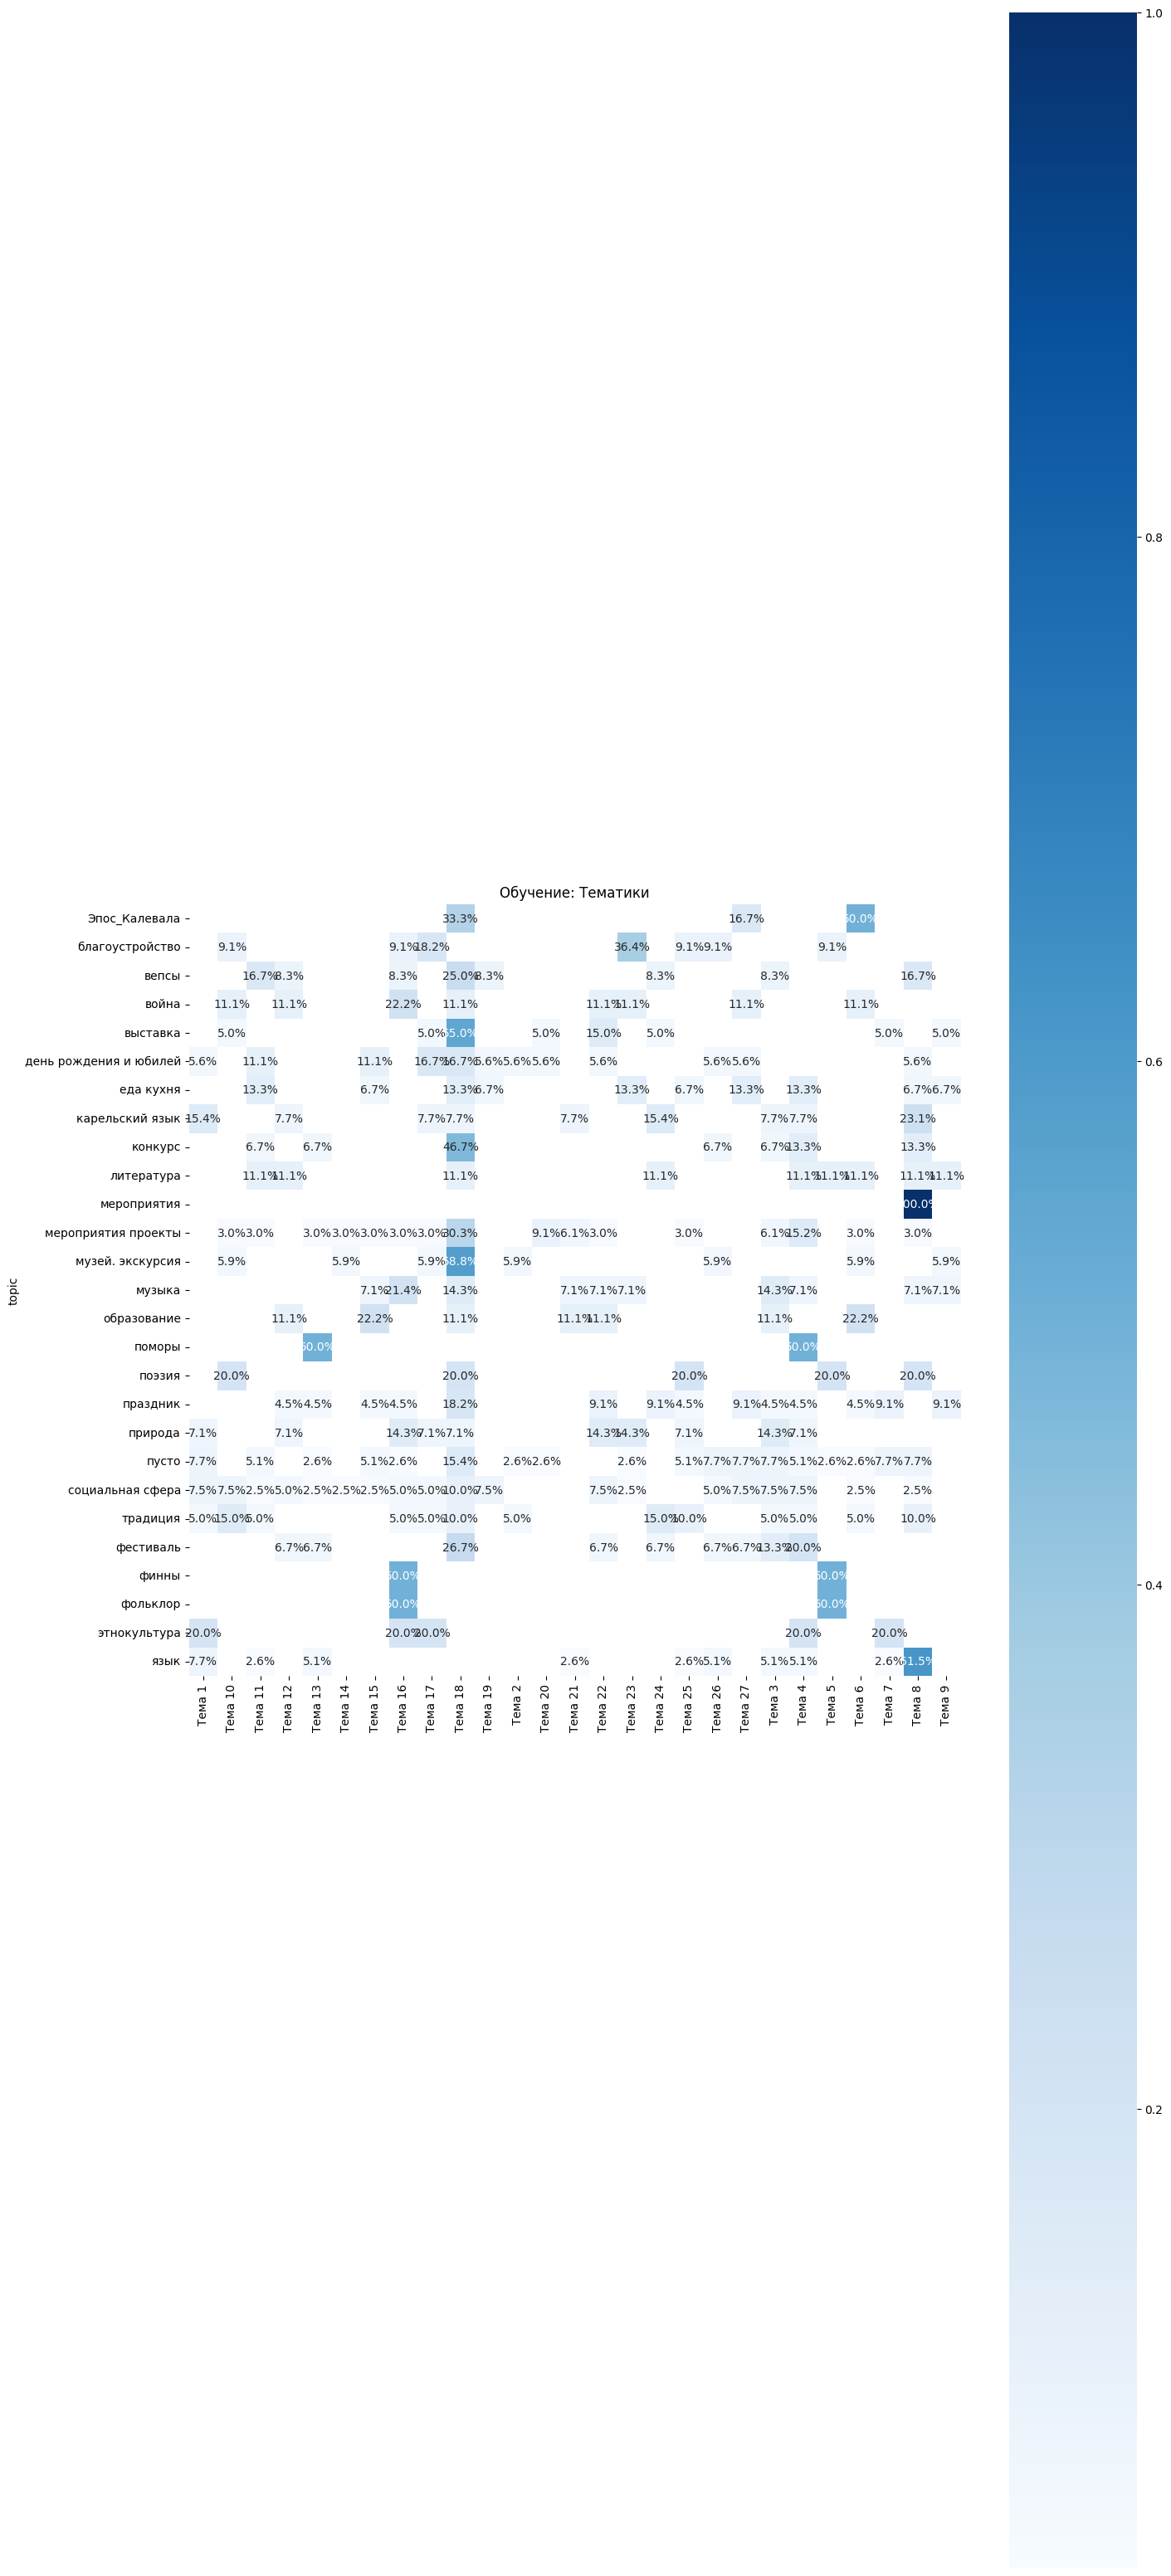

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
df = train_eval.groupby(level='topic').idxmax(
    axis=1).reset_index(-1, drop=True)
plt.figure(figsize=(15, 40))
sns.heatmap(df.groupby(level='topic').value_counts(normalize=True)
            .unstack(-1), annot=True, fmt='.1%', cmap='Blues', square=True)
plt.title('–û–±—É—á–µ–Ω–∏–µ: –¢–µ–º–∞—Ç–∏–∫–∏')


In [ ]:
train_eval = pd.DataFrame(train_preds, columns=topic_labels, index=train_docs.topic)
train_eval

–¢–µ–º–∞ 1    –¢–µ–º–∞ 2    –¢–µ–º–∞ 3    –¢–µ–º–∞ 4    –¢–µ–º–∞ 5    –¢–µ–º–∞ 6  \
topic                                                                          
–≤–µ–ø—Å—ã             0.009515  0.009515  0.009515  0.009515  0.009515  0.009515   
–ø—Ä–∏—Ä–æ–¥–∞           0.012425  0.012425  0.012425  0.676947  0.012425  0.012425   
–º—É–∑–µ–π. —ç–∫—Å–∫—É—Ä—Å–∏—è  0.004767  0.004767  0.004767  0.092038  0.196650  0.004767   
–≤—ã—Å—Ç–∞–≤–∫–∞          0.005669  0.005669  0.067344  0.119127  0.005669  0.005669   
–∫–æ–Ω–∫—É—Ä—Å           0.007791  0.007791  0.007791  0.007791  0.007791  0.007791   
...                    ...       ...       ...       ...       ...       ...   
—è–∑—ã–∫              0.008122  0.008122  0.008122  0.008122  0.008122  0.008122   
–ø—Ä–∏—Ä–æ–¥–∞           0.005828  0.005828  0.005828  0.005828  0.005828  0.005828   
–º—É–∑—ã–∫–∞            0.004562  0.004562  0.245032  0.065191  0.004562  0.004562   
–ø—Ä–∞–∑–¥–Ω–∏–∫          0.015341  0.015341  0.015341  0.015341  0.015341  0.601123   
–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ       0.009307  0.009307  0.009307  0.009307  0.009307  0.009307   

                    –¢–µ–º–∞ 7    –¢–µ–º–∞ 8    –¢–µ–º–∞ 9   –¢–µ–º–∞ 10  ...   –¢–µ–º–∞ 18  \
topic                                                     ...             
–≤–µ–ø—Å—ã             0.009515  0.009515  0.009515  0.009515  ...  0.752610   
–ø—Ä–∏—Ä–æ–¥–∞           0.012425  0.012425  0.012425  0.012425  ...  0.012425   
–º—É–∑–µ–π. —ç–∫—Å–∫—É—Ä—Å–∏—è  0.057407  0.066858  0.004767  0.004767  ...  0.300825   
–≤—ã—Å—Ç–∞–≤–∫–∞          0.005669  0.005669  0.005669  0.005669  ...  0.288078   
–∫–æ–Ω–∫—É—Ä—Å           0.007791  0.007791  0.007791  0.007791  ...  0.246385   
...                    ...       ...       ...       ...  ...       ...   
—è–∑—ã–∫              0.008122  0.150349  0.008122  0.008122  ...  0.008122   
–ø—Ä–∏—Ä–æ–¥–∞           0.005828  0.005828  0.005828  0.005828  ...  0.236987   
–º—É–∑—ã–∫–∞            0.004562  0.147905  0.004562  0.004562  ...  0.229913   
–ø—Ä–∞–∑–¥–Ω–∏–∫          0.015341  0.015341  0.015341  0.015341  ...  0.015341   
–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ       0.009307  0.009307  0.009307  0.009307  ...  0.009307   

                   –¢–µ–º–∞ 19   –¢–µ–º–∞ 20   –¢–µ–º–∞ 21   –¢–µ–º–∞ 22   –¢–µ–º–∞ 23   –¢–µ–º–∞ 24  \
topic                                                                          
–≤–µ–ø—Å—ã             0.009515  0.009515  0.009515  0.009515  0.009515  0.009515   
–ø—Ä–∏—Ä–æ–¥–∞           0.012425  0.012425  0.012425  0.012425  0.012425  0.012425   
–º—É–∑–µ–π. —ç–∫—Å–∫—É—Ä—Å–∏—è  0.004767  0.004767  0.004767  0.004767  0.004767  0.004767   
–≤—ã—Å—Ç–∞–≤–∫–∞          0.005669  0.005669  0.005669  0.005669  0.005669  0.005669   
–∫–æ–Ω–∫—É—Ä—Å           0.007791  0.007791  0.007791  0.007791  0.007791  0.007791   
...                    ...       ...       ...       ...       ...       ...   
—è–∑—ã–∫              0.008122  0.008122  0.008122  0.008122  0.008122  0.008122   
–ø—Ä–∏—Ä–æ–¥–∞           0.005828  0.005828  0.005828  0.005828  0.005828  0.005828   
–º—É–∑—ã–∫–∞            0.004562  0.004562  0.004562  0.004562  0.004562  0.004562   
–ø—Ä–∞–∑–¥–Ω–∏–∫          0.015341  0.015341  0.015341  0.015341  0.015341  0.015341   
–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ       0.009307  0.009307  0.009307  0.009307  0.009307  0.009307   

                   –¢–µ–º–∞ 25   –¢–µ–º–∞ 26   –¢–µ–º–∞ 27  
topic                                           
–≤–µ–ø—Å—ã             0.009515  0.009515  0.009515  
–ø—Ä–∏—Ä–æ–¥–∞           0.012425  0.012425  0.012425  
–º—É–∑–µ–π. —ç–∫—Å–∫—É—Ä—Å–∏—è  0.004767  0.004767  0.004767  
–≤—ã—Å—Ç–∞–≤–∫–∞          0.005669  0.005669  0.005669  
–∫–æ–Ω–∫—É—Ä—Å           0.007791  0.007791  0.007791  
...                    ...       ...       ...  
—è–∑—ã–∫              0.008122  0.008122  0.008122  
–ø—Ä–∏—Ä–æ–¥–∞           0.005828  0.005828  0.005828  
–º—É–∑—ã–∫–∞            0.004562  0.004562  0.004562  
–ø—Ä–∞–∑–¥–Ω–∏–∫          0.015341  0.015341  0.015341

In [ ]:
df = train_eval.groupby(level='topic').idxmax(
    axis=1).reset_index(-1, drop=True)
train_eval = pd.DataFrame(data=lda.transform(doc_train_matrix),
                          columns=topic_labels,
                          index=train_docs.topic)
test_eval = pd.DataFrame(data=lda.transform(doc_test_matrix),
                         columns=topic_labels,
                         index=test_docs.topic)

<ipython-input-29-827e74a28c9f>:1: FutureWarning: DataFrameGroupBy.idxmax with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  df = train_eval.groupby(level='topic').idxmax(


**–í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è –≤ –≤–∏–¥–µ —Ç–µ–ø–ª–æ–≤–æ–π –∫–∞—Ä—Ç—ã (heatmap) –¥–ª—è –∞–Ω–∞–ª–∏–∑–∞ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è —Ç–µ–º –≤ –Ω–∞–±–æ—Ä–µ –¥–∞–Ω–Ω—ã—Ö: —Ç–µ—Å—Ç–æ–≤—ã–π (test_eval)**

<ipython-input-37-b3ab076de811>:1: FutureWarning: DataFrameGroupBy.idxmax with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  df = test_eval.groupby(level='topic').idxmax(


Text(0.5, 1.0, '–î–∞–Ω–Ω—ã–µ –æ–±—É—á–µ–Ω–∏—è: –¢–µ–º–∞—Ç–∏—á–µ—Å–∫–∏–µ –∑–∞–¥–∞–Ω–∏—è')

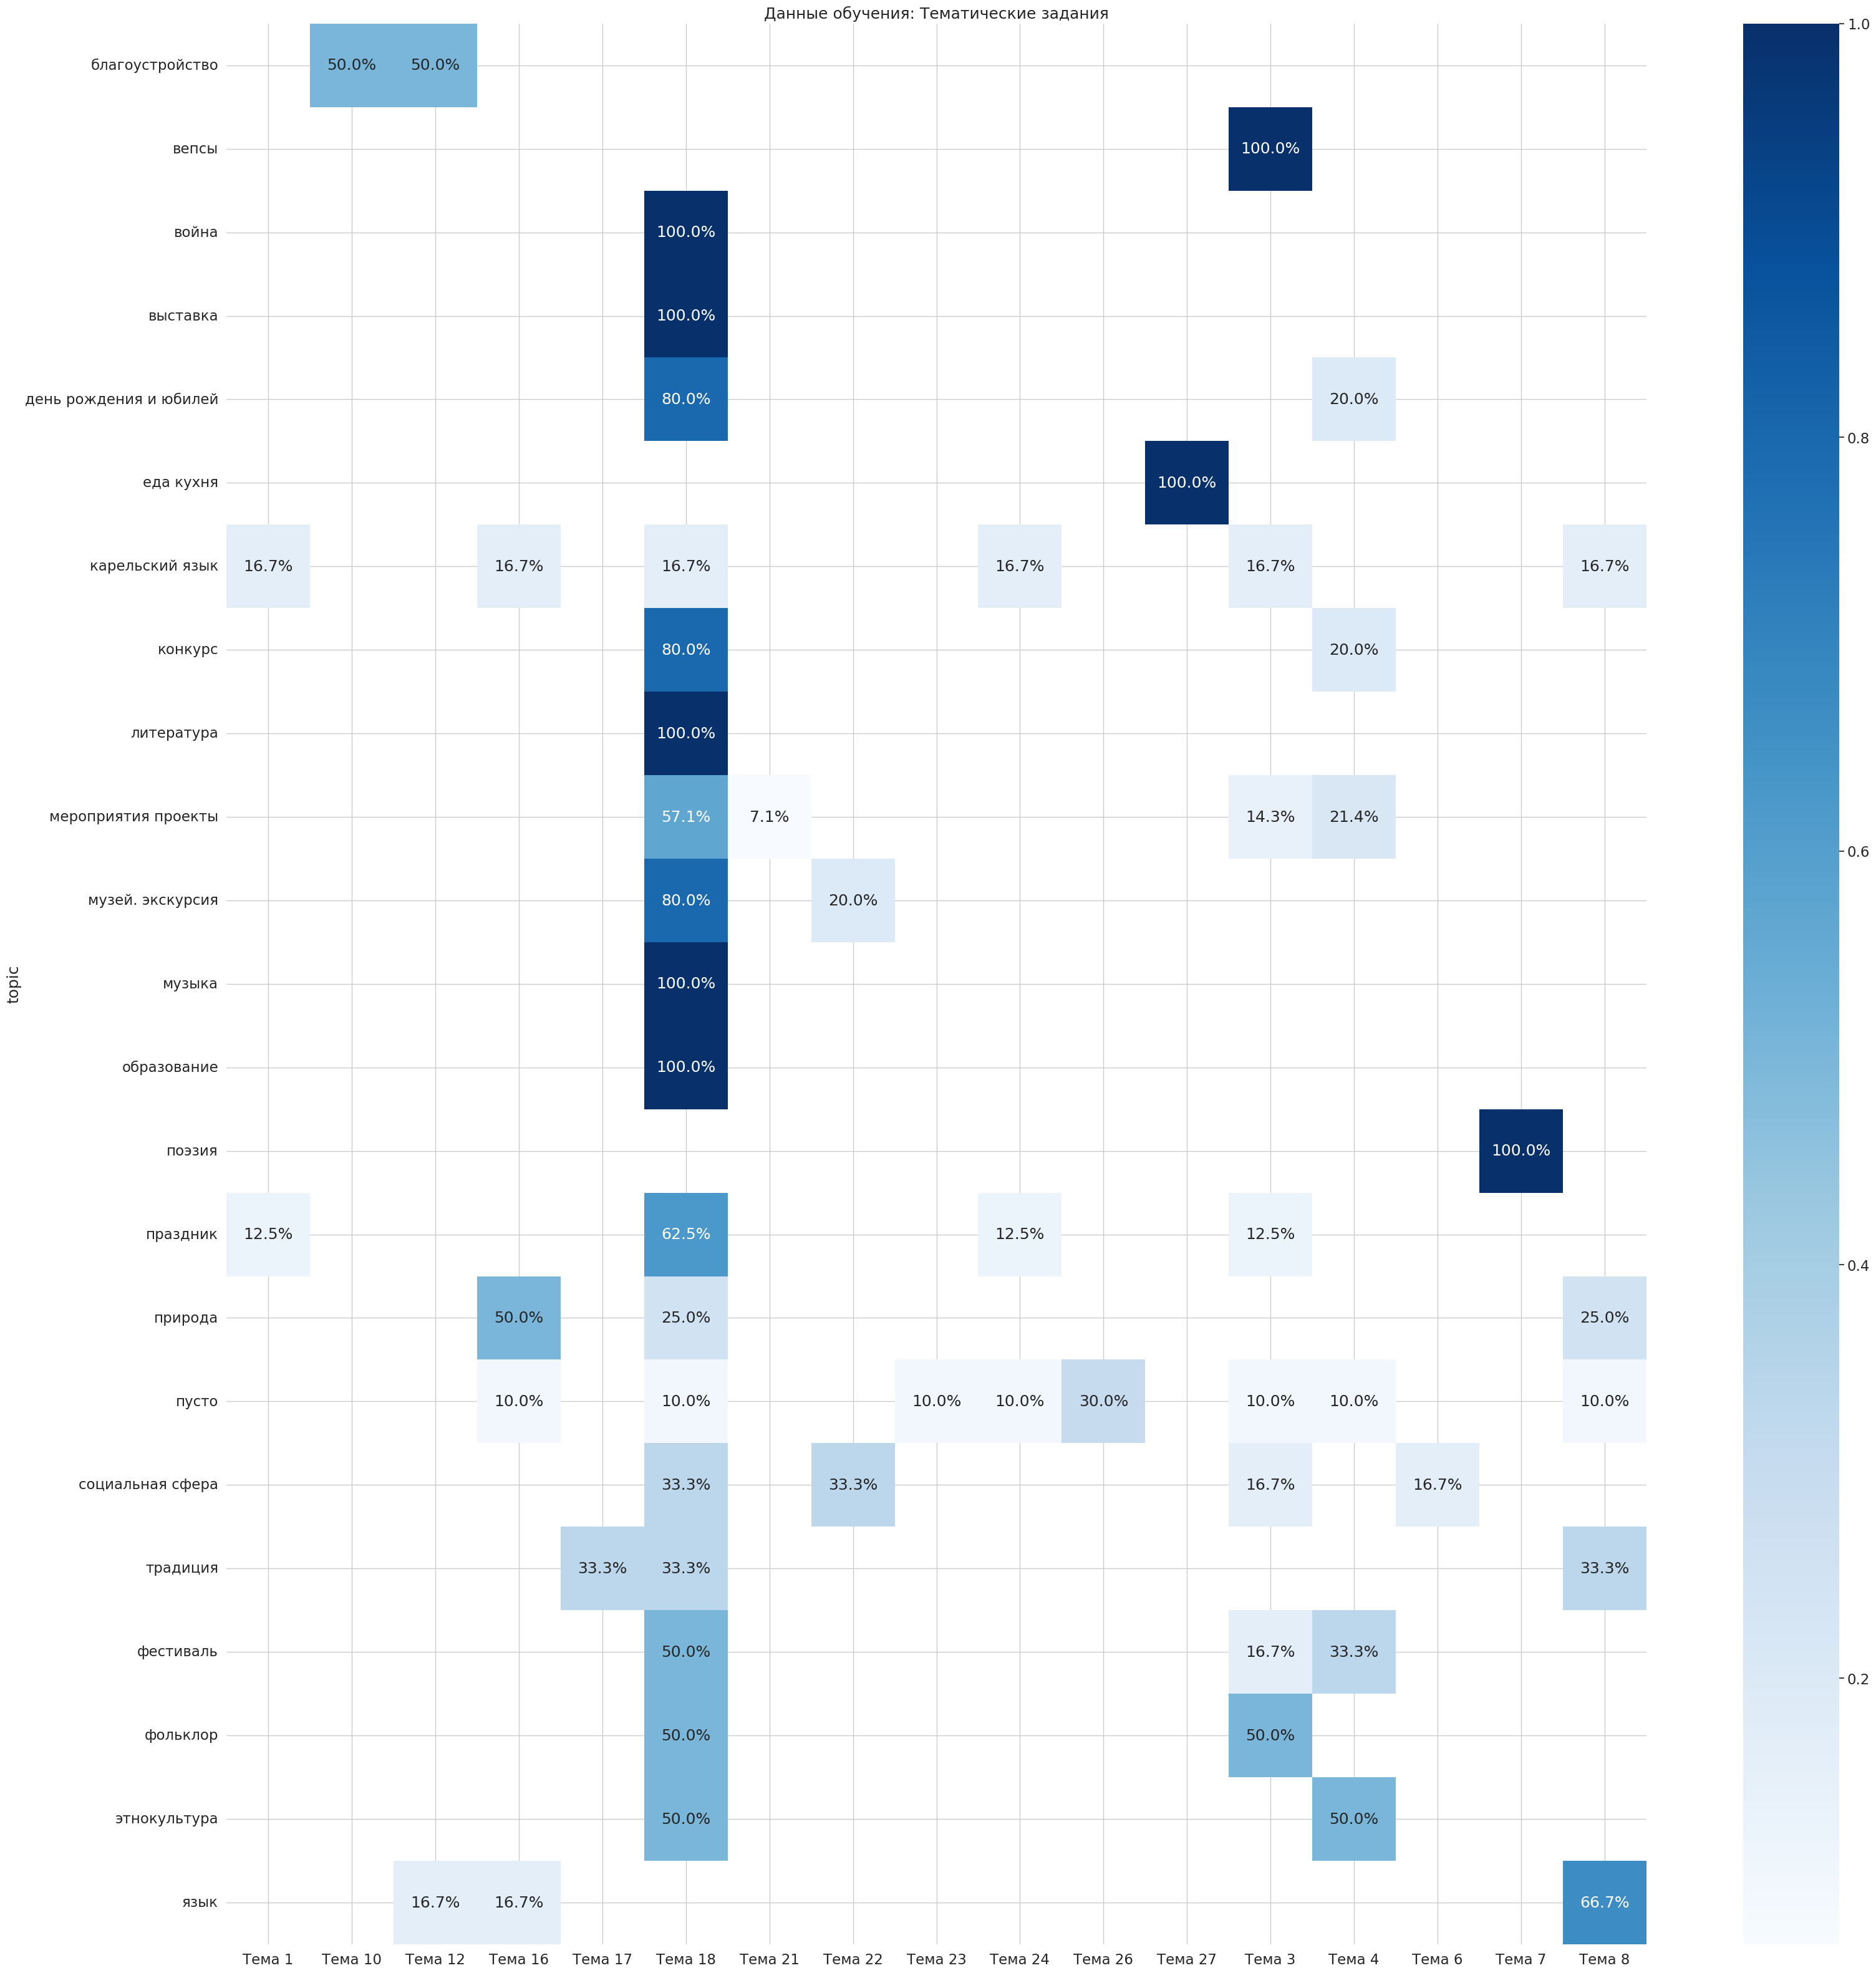

In [ ]:
df = test_eval.groupby(level='topic').idxmax(
    axis=1).reset_index(-1, drop=True)
plt.figure(figsize=(40, 40))
sns.heatmap(df.groupby(level='topic').value_counts(normalize=True)
            .unstack(-1), annot=True, fmt='.1%', cmap='Blues', square=True)
plt.title('–î–∞–Ω–Ω—ã–µ –æ–±—É—á–µ–Ω–∏—è: –¢–µ–º–∞—Ç–∏—á–µ—Å–∫–∏–µ –∑–∞–¥–∞–Ω–∏—è')

In [ ]:
test_assignments = test_eval.groupby(level='topic').idxmax(
    axis=1).reset_index(-1, drop=True).to_frame('predicted').reset_index()
test_assignments['text'] = test_docs.text.values
test_assignments.head(5)

<ipython-input-30-c37182911221>:1: FutureWarning: DataFrameGroupBy.idxmax with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  test_assignments = test_eval.groupby(level='topic').idxmax(


topic predicted  \
0  –±–ª–∞–≥–æ—É—Å—Ç—Ä–æ–π—Å—Ç–≤–æ   –¢–µ–º–∞ 12   
1  –±–ª–∞–≥–æ—É—Å—Ç—Ä–æ–π—Å—Ç–≤–æ   –¢–µ–º–∞ 10   
2            –≤–µ–ø—Å—ã    –¢–µ–º–∞ 3   
3            –≤–æ–π–Ω–∞   –¢–µ–º–∞ 18   
4            –≤–æ–π–Ω–∞   –¢–µ–º–∞ 18   

                                                text  
0  üö© –°—Ç—Ä–∞–Ω–∏—Ü—ã –∏—Å—Ç–æ—Ä–∏–∏ –≥.–û–ª–æ–Ω–µ—Ü –±—ã–ª –æ–∫–∫—É–ø–∏—Ä–æ–≤–∞–Ω 6 ...  
1  –î—Ä—É–∑—å—èüëçüèª  –ê –ø–æ—á–µ–º—É –±—ã –Ω–µ –Ω–∞–ø–æ–º–Ω–∏—Ç—å –í–∞–º, —á—Ç–æ —É ...  
2  –í —á–µ—Ç–≤–µ—Ä–≥, 27 –æ–∫—Ç—è–±—Ä—è, –≤ –ø—Ä—è–º–æ–º —ç—Ñ–∏—Ä–µ –≤ —Ä–∞–º–∫–∞—Ö...  
3  –ü–µ—Ä–≤–∞—è –ø—Ä–æ—Å–≤–µ—Ç–∏—Ç–µ–ª—å—Å–∫–∞—è –∞–∫—Ü–∏—è ¬´–î—É—à–∞ –æ–¥–Ω–∞ –Ω–∞ –≤—Å...  
4  9 –∞–≤–≥—É—Å—Ç–∞ –†–µ—Å–ø—É–±–ª–∏–∫–∞ –ö–∞—Ä–µ–ª–∏—è –æ—Ç–º–µ—Ç–∏—Ç –ú–µ–∂–¥—É–Ω–∞—Ä–æ...

In [ ]:
test_assignments = (test_eval.groupby(level='topic').idxmax(axis=1)
                   .reset_index(-1, drop=True)
                   .to_frame('predicted')
                   .reset_index())

test_assignments['text'] = test_docs.text.values

war_assignments = test_assignments[test_assignments['topic'] == '–≤–æ–π–Ω–∞']
war_assignments
war_assignments.to_csv("war.csv")

<ipython-input-43-2aea02cd00df>:1: FutureWarning: DataFrameGroupBy.idxmax with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  test_assignments = (test_eval.groupby(level='topic').idxmax(axis=1)


In [ ]:
test_assignments.to_csv("res.csv")